# STORM

[STORM](https://arxiv.org/abs/2402.14207) is a research assistant designed by Shao, et. al that extends the idea of "outline-driven RAG" for richer article generation.

This notebook is an implementation of the article's DSPy framework to LangChain Expression Language (LCEL) .

STORM is designed to generate Wikipedia-style ariticles on a user-provided topic. It applies two main insights to produce more organized and comprehensive articles:

1. Creating an outline (planning) by querying similar topics helps improve coverage.
2. Multi-perspective, grounded (in search) conversation simulation helps increase the reference count and information density. 

The control flow looks like the diagram below.

(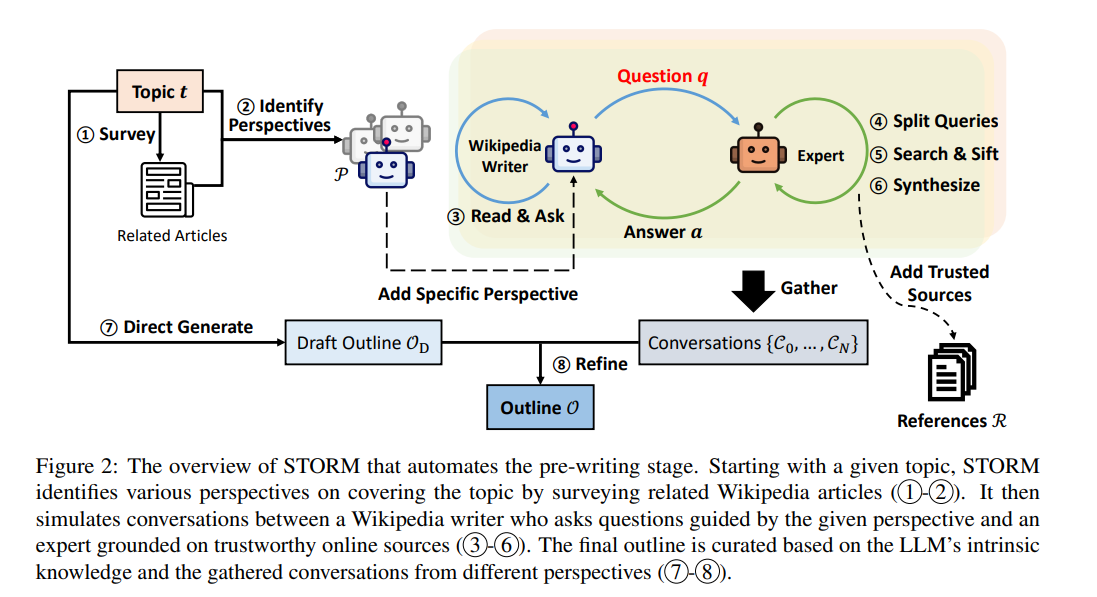)


STORM operates through several key phases:

1. Crafting an initial outline and exploring related topics.
2. Selecting diverse viewpoints.
3. Conducting "expert interviews" via simulating conversations with language models.
4. Enhancing the outline with sourced references.
5. Composing individual sections before assembling the final article.
6. During the "expert interviews" phase, the simulated role of an article writer engages with a research expert. This "expert" has the capability to search for external information and answer specific inquiries, documenting referenced sources in a vectorstore. This process enables the subsequent stages to integrate these insights into the comprehensive article.

To manage the scope of research, which could otherwise become overwhelmingly broad, you can adjust two hyperparameters:

N: The number of viewpoints to consider and include (from Stage 2 to Stage 3).

M: The maximum number of exchanges in the interview phase (Stage 3).



## Prerequisites

In [1]:
!pip install -U langchain_community langchain_openai langgraph wikipedia  scikit-learn graphviz
!pip install -U tavily-python #I recommend to use Tavily search engine, but you need to obtain the API-key via web site app.tavily.com 

   ---------------------------------------- 0.0/47.2 kB ? eta -:--:--
   ----------------- ---------------------- 20.5/47.2 kB 330.3 kB/s eta 0:00:01
   ---------------------------------------- 47.2/47.2 kB 596.4 kB/s eta 0:00:00


ERROR: Invalid requirement: '#I'


In [2]:
import os
import getpass


def _set_env(var: str):
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var + ":")


# Set for tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "STORM"
_set_env("LANGCHAIN_API_KEY")
_set_env("TAVILY_API_KEY") 
_set_env("OPENAI_API_KEY")

#### Select LLMs

We will have a faster LLM do most of the work, but a slower, long-context model to distill the conversations and write the final report.

In [3]:
from langchain_openai import ChatOpenAI

fast_llm = ChatOpenAI(model="gpt-3.5-turbo")
long_context_llm = ChatOpenAI(model="gpt-4-turbo-preview")

## Generate Initial Outline

For many topics, your LLM may have an initial idea of the important and related topics. We can generate an initial
outline to be refined after our research. Below, we will use our "fast" llm to generate the outline.

In [4]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Optional
from langchain_core.prompts import ChatPromptTemplate

direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a Wikipedia writer. Write an outline for a Wikipedia page about a user-provided topic. Be comprehensive and specific.",
        ),
        ("user", "{topic}"),
    ]
)


class Subsection(BaseModel):
    subsection_title: str = Field(..., title="Title of the subsection")
    description: str = Field(..., title="Content of the subsection")

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.description}".strip()


class Section(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    description: str = Field(..., title="Content of the section")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="Titles and descriptions for each subsection of the Wikipedia page.",
    )

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            f"### {subsection.subsection_title}\n\n{subsection.description}"
            for subsection in self.subsections or []
        )
        return f"## {self.section_title}\n\n{self.description}\n\n{subsections}".strip()


class Outline(BaseModel):
    page_title: str = Field(..., title="Title of the Wikipedia page")
    sections: List[Section] = Field(
        default_factory=list,
        title="Titles and descriptions for each section of the Wikipedia page.",
    )

    @property
    def as_str(self) -> str:
        sections = "\n\n".join(section.as_str for section in self.sections)
        return f"# {self.page_title}\n\n{sections}".strip()


generate_outline_direct = direct_gen_outline_prompt | fast_llm.with_structured_output(
    Outline
)

c:\Users\Nick\anaconda3\envs\AIsys\Lib\site-packages\langchain_core\_api\beta_decorator.py:86: LangChainBetaWarning: The function `with_structured_output` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


In [5]:
example_topic = "Generative AI + Education: Will Generative AI Transform Learning and Education to better or worse?" 

initial_outline = generate_outline_direct.invoke({"topic": example_topic})

print(initial_outline.as_str)

# Generative AI in Education

## Introduction

Overview of generative AI and its potential impact on learning and education.

## Benefits of Generative AI in Education

Exploring the positive implications of using generative AI in the field of education.

### Personalized Learning

How generative AI can tailor educational content to individual students' needs.

### Interactive Learning Experiences

The role of generative AI in creating engaging and interactive learning environments.

### Innovative Teaching Methods

Examples of how generative AI can facilitate new teaching strategies and approaches.

## Challenges and Concerns

Examining the potential drawbacks and ethical considerations of integrating generative AI into education.

## Case Studies

Real-world examples of generative AI applications in educational settings and their outcomes.

## Future Outlook

Predictions and trends regarding the future of generative AI in the realm of learning and education.


## Expand Topics

While language models do store some Wikipedia-like knowledge in their parameters, you will get better results by incorporating relevant and recent information using a search engine.

We will start our search by generating a list of related topics, sourced from Wikipedia.

In [6]:
gen_related_topics_prompt = ChatPromptTemplate.from_template(
    """I'm writing a Wikipedia page for a topic mentioned below. Please identify and recommend some Wikipedia pages on closely related subjects. I'm looking for examples that provide insights into interesting aspects commonly associated with this topic, or examples that help me understand the typical content and structure included in Wikipedia pages for similar topics.

Please list the as many subjects and urls as you can.

Topic of interest: {topic}
"""
)


class RelatedSubjects(BaseModel):
    topics: List[str] = Field(
        description="Comprehensive list of related subjects as background research.",
    )


expand_chain = gen_related_topics_prompt | fast_llm.with_structured_output(
    RelatedSubjects
)

In [7]:
related_subjects = await expand_chain.ainvoke({"topic": example_topic})
related_subjects

RelatedSubjects(topics=['Generative AI', 'Education', 'Artificial Intelligence', 'Machine Learning', 'Deep Learning', 'Transformative Technology', 'Learning and Education'])

## Generate Perspectives

From these related subjects, we can select representative Wikipedia editors as "subject matter experts" with distinct
backgrounds and affiliations. These will help distribute the search process to encourage a more well-rounded final report.

In [8]:
class Editor(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the editor.",
    )
    name: str = Field(
        description="Name of the editor.",
    )
    role: str = Field(
        description="Role of the editor in the context of the topic.",
    )
    description: str = Field(
        description="Description of the editor's focus, concerns, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


class Perspectives(BaseModel):
    editors: List[Editor] = Field(
        description="Comprehensive list of editors with their roles and affiliations.",
        # Add a pydantic validation/restriction to be at most M editors
    )


gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You need to select a diverse (and distinct) group of Wikipedia editors who will work together to create a comprehensive article on the topic. Each of them represents a different perspective, role, or affiliation related to this topic.\
    You can use other Wikipedia pages of related topics for inspiration. For each editor, add a description of what they will focus on.

    Wiki page outlines of related topics for inspiration:
    {examples}""",
        ),
        ("user", "Topic of interest: {topic}"),
    ]
)

gen_perspectives_chain = gen_perspectives_prompt | ChatOpenAI(
    model="gpt-4-turbo-preview"
).with_structured_output(Perspectives)

In [10]:
from langchain_community.retrievers import WikipediaRetriever
from langchain_core.runnables import RunnableLambda, chain as as_runnable

wikipedia_retriever = WikipediaRetriever(load_all_available_meta=True, top_k_results=3) #1


def format_doc(doc, max_length=10000): #1000
    related = "- ".join(doc.metadata["categories"])
    return f"### {doc.metadata['title']}\n\nSummary: {doc.page_content}\n\nRelated\n{related}"[
        :max_length
    ]


def format_docs(docs):
    return "\n\n".join(format_doc(doc) for doc in docs)


@as_runnable
async def survey_subjects(topic: str):
    related_subjects = await expand_chain.ainvoke({"topic": topic})
    retrieved_docs = await wikipedia_retriever.abatch(
        related_subjects.topics, return_exceptions=True
    )
    all_docs = []
    for docs in retrieved_docs:
        if isinstance(docs, BaseException):
            continue
        all_docs.extend(docs)
    formatted = format_docs(all_docs)
    return await gen_perspectives_chain.ainvoke({"examples": formatted, "topic": topic})

In [11]:
perspectives = await survey_subjects.ainvoke(example_topic)

In [12]:
perspectives.dict()

{'editors': [{'affiliation': 'OpenAI',
   'name': 'Dr. Jane Smith',
   'role': 'AI Research Scientist',
   'description': 'Focus on the development and ethical implications of generative AI, particularly in educational contexts. Concerned with how generative AI can enhance personalized learning experiences but wary of potential misuse and data privacy issues.'},
  {'affiliation': 'University of Technology',
   'name': 'Prof. Michael Brown',
   'role': 'Educational Technologist',
   'description': 'Examines the integration of technology into teaching and learning. Interested in the potential of generative AI to revolutionize education by providing adaptive learning environments but worried about the digital divide and accessibility.'},
  {'affiliation': 'Global Educational Policy Institute',
   'name': 'Ms. Ayesha Khan',
   'role': 'Educational Policy Analyst',
   'description': 'Evaluates the impact of educational policies on learning outcomes. Focuses on the implications of implementi

## Expert Dialog

Now the true fun begins, each wikipedia writer is primed to role-play using the perspectives presented above. It will ask a series of questions of a second "domain expert" with access to a search engine. This generate content to generate a refined outline as well as an updated index of reference documents.


### Interview State

The conversation is cyclic, so we will construct it within its own graph. The State will contain messages, the reference docs, and the editor (with its own "persona") to make it easy to parallelize these conversations.

In [13]:
from langgraph.graph import StateGraph, END
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated, Sequence


def add_messages(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return left + right


def update_references(references, new_references):
    if not references:
        references = {}
    references.update(new_references)
    return references


def update_editor(editor, new_editor):
    # Can only set at the outset
    if not editor:
        return new_editor
    return editor


class InterviewState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    references: Annotated[Optional[dict], update_references]
    editor: Annotated[Optional[Editor], update_editor]

#### Dialog Roles

The graph will have two participants: the wikipedia editor (`generate_question`), who asks questions based on its assigned role, and a domain expert (`gen_answer_chain), who uses a search engine to answer the questions as accurately as possible.

In [14]:
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage

gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an experienced Wikipedia writer and want to edit a specific page. \
Besides your identity as a Wikipedia writer, you have a specific focus when researching the topic. \
Now, you are chatting with an expert to get information. Ask good questions to get more useful information.

When you have no more questions to ask, say "Thank you so much for your help!" to end the conversation.\
Please only ask one question at a time and don't ask what you have asked before.\
Your questions should be related to the topic you want to write.
Be comprehensive and curious, gaining as much unique insight from the expert as possible.\

Stay true to your specific perspective:

{persona}""",
        ),
        # A placeholder for dynamically inserting a sequence of messages into the prompt,
        # allowing the conversation to build upon previous exchanges.
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

# Function to add a specific name tag to AI-generated messages. This is useful for
# tracking the source of messages and potentially filtering or processing them differently.
def tag_with_name(ai_message: AIMessage, name: str):
    ai_message.name = name
    return ai_message

# Function to swap the roles of messages in the state, converting AI messages to Human
# messages if they do not originate from the current editor. This simulates a dynamic
# conversation where roles can shift, reflecting the fluid nature of real dialogues.
def swap_roles(state: InterviewState, name: str):
    converted = []
    for message in state["messages"]:
        # If a message is identified as being from the AI but not from the current
        # named editor, it's transformed into a HumanMessage to simulate a response
        # from the expert or another participant in the conversation.
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.dict(exclude={"type"}))
        converted.append(message)
    return {"messages": converted}

# An asynchronous function decorated to be runnable within the langchain framework,
# designed to generate a new question based on the current state of the conversation
# and the editor's specific perspective or persona.
@as_runnable
async def generate_question(state: InterviewState):
    editor = state["editor"]
    # Constructs a chain of operations starting with role swapping, then generating a
    # question based on the editor's persona, processing the prompt through a fast
    # language model, and finally tagging the AI's response with the editor's name.
    gn_chain = (
        RunnableLambda(swap_roles).bind(name=editor.name)  # Prepare messages for prompt
        | gen_qn_prompt.partial(persona=editor.persona)  # Generate prompt with editor persona
        | fast_llm  # Process the prompt through a language model for generating a question
        | RunnableLambda(tag_with_name).bind(name=editor.name)  # Tag the response with the editor's name
    )
    # Execute the chain with the current conversation state, generating a new question.
    result = await gn_chain.ainvoke(state)
    return {"messages": [result]}  # Update the conversation state with the new question.


In [15]:
messages = [
    HumanMessage(f"So you said you were writing an article on {example_topic}?")
]
question = await generate_question.ainvoke(
    {
        "editor": perspectives.editors[0],
        "messages": messages,
    }
)

question["messages"][0].content

"Yes, that's correct. I'm particularly interested in exploring how generative AI can enhance personalized learning experiences while also considering the potential risks and ethical implications associated with its use in educational contexts. Can you provide insights on how generative AI is currently being utilized in education and the potential impact it may have on transforming learning experiences for better or worse?"

#### Answer questions

The `gen_answer_chain` first generates queries (query expansion) to answer the editor's question, then responds with citations.

In [16]:
class Queries(BaseModel):
    queries: List[str] = Field(
        description="Comprehensive list of search engine queries to answer the user's questions.",
    )


gen_queries_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful research assistant. Query the search engine to answer the user's questions.",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)
gen_queries_chain = gen_queries_prompt | ChatOpenAI(
    model="gpt-3.5-turbo"
).with_structured_output(Queries, include_raw=True)

In [17]:
queries = await gen_queries_chain.ainvoke(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
queries["parsed"].queries

['Current applications of generative AI in education',
 'Potential impact of generative AI on learning experiences',
 'Ethical implications of using generative AI in education']

In [18]:
class AnswerWithCitations(BaseModel):
    answer: str = Field(
        description="Comprehensive answer to the user's question with citations.",
    )
    cited_urls: List[str] = Field(
        description="List of urls cited in the answer.",
    )

    @property
    def as_str(self) -> str:
        return f"{self.answer}\n\nCitations:\n\n" + "\n".join(
            f"[{i+1}]: {url}" for i, url in enumerate(self.cited_urls)
        )


gen_answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert who can use information effectively. You are chatting with a Wikipedia writer who wants\
 to write a Wikipedia page on the topic you know. You have gathered the related information and will now use the information to form a response.

Make your response as informative as possible and make sure every sentence is supported by the gathered information.
Each response must be backed up by a citation from a reliable source, formatted as a footnote, reproducing the URLS after your response.""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

gen_answer_chain = gen_answer_prompt | fast_llm.with_structured_output(
    AnswerWithCitations, include_raw=True
).with_config(run_name="GenerateAnswer")

In [64]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

search_engine = TavilySearchResults(max_results=4, search_depth="advanced")

@tool
async def search_engine(query: str):
    """Search engine to the internet."""
    results = search_engine.ainvoke(query)
    return [{"content": r["content"], "url": r["url"]} for r in results]

In [65]:
from langchain_core.runnables import RunnableConfig
import json

# Define the asynchronous function to generate an answer based on the current state of the interview.
async def gen_answer(
    state: InterviewState,  # The current state of the interview, including messages and possibly references.
    config: Optional[RunnableConfig] = None,  # Configuration options for the runnable, if any.
    name: str = "Subject Matter Expert",  # Name of the role to assume when generating answers.
    max_str_len: int = 30000,  # Maximum string length to ensure responses do not exceed token limits.(10000-30000)
):
    # Swap the roles for all messages in the state to reflect the perspective of the subject matter expert.
    swapped_state = swap_roles(state, name)

    # Generate queries based on the swapped state, using an asynchronous chain of operations.
    queries = await gen_queries_chain.ainvoke(swapped_state)

    # Use a batch process to send all generated queries to a search engine asynchronously, handling exceptions.
    query_results = await search_engine.abatch(
        queries["parsed"].queries, config, return_exceptions=True
    )

    # Filter out successful results, ignoring any exceptions encountered during the search.
    successful_results = [
        res for res in query_results if not isinstance(res, Exception)
    ]

    
    all_query_results = {
        res["url"]: res["content"] for results in successful_results for res in results
    }

    # Prepare the aggregated results for inclusion in the response, truncating if necessary.
    dumped = json.dumps(all_query_results)[:max_str_len]

    # Prepare messages to reflect the query and its results in the interaction history.
    ai_message: AIMessage = queries["raw"]
    tool_call = queries["raw"].additional_kwargs["tool_calls"][0]
    tool_id = tool_call["id"]
    tool_message = ToolMessage(tool_call_id=tool_id, content=dumped)

    # Update the interaction history with the query and its results.
    swapped_state["messages"].extend([ai_message, tool_message])

    # Generate the final answer based on the updated state, including the search results.
    generated = await gen_answer_chain.ainvoke(swapped_state)

    # Extract URLs cited in the generated answer for future reference.
    cited_urls = set(generated["parsed"].cited_urls)

    # Save the content associated with cited URLs in a separate dictionary for reference.
    cited_references = {k: v for k, v in all_query_results.items() if k in cited_urls}

    # Format the final message as an AIMessage from the subject matter expert.
    formatted_message = AIMessage(name=name, content=generated["parsed"].as_str)

    # Return the updated state including the final formatted message and any cited references.
    return {"messages": [formatted_message], "references": cited_references}


In [67]:
example_answer = await gen_answer(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
example_answer["messages"][-1].content
example_answer["references"] # double check that references have extracted

C:\Users\Nick\AppData\Local\Temp\ipykernel_6676\4130268604.py:1: RuntimeWarning: coroutine 'StructuredTool.ainvoke' was never awaited
  example_answer = await gen_answer(


{}

#### Construct the Interview Graph


Now that we've defined the editor and domain expert, we can compose them in a graph.

In [41]:
max_num_turns = 5


def route_messages(state: InterviewState, name: str = "Subject Matter Expert"):
    messages = state["messages"]
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    if num_responses >= max_num_turns:
        return END
    last_question = messages[-2]
    if last_question.content.endswith("Thank you so much for your help!"):
        return END
    return "ask_question"


builder = StateGraph(InterviewState)

builder.add_node("ask_question", generate_question)
builder.add_node("answer_question", gen_answer)
builder.add_conditional_edges("answer_question", route_messages)
builder.add_edge("ask_question", "answer_question")

builder.set_entry_point("ask_question")
interview_graph = builder.compile().with_config(run_name="Conduct Interviews")

In [ ]:
#!pip install pygraphviz

In [ ]:
#from IPython.display import Image

# Feel free to comment out if you have
# not installed pygraphviz or have an errror pyproject.toml-based projects 
#Image(interview_graph.get_graph().draw_png())

In [42]:
final_step = None

initial_state = {
    "editor": perspectives.editors[0],
    "messages": [
        AIMessage(
            content=f"So you said you were writing an article on {example_topic}?",
            name="Subject Matter Expert",
        )
    ],
}
async for step in interview_graph.astream(initial_state):
    name = next(iter(step))
    print(name)
    print("-- ", str(step[name]["messages"])[:300])
    if END in step:
        final_step = step

ask_question
--  [AIMessage(content="Yes, that's correct. I believe that generative AI has the potential to greatly enhance personalized learning experiences for students by providing tailored educational content and support. However, I am also concerned about the ethical implications and potential misuse of generat
answer_question
--  [AIMessage(content="Generative AI is being used in educational settings to create personalized learning experiences through adaptive content generation, intelligent tutoring systems, and automated feedback mechanisms. For example, platforms like Carnegie Learning's Mika provide personalized math tut
ask_question
--  [AIMessage(content='Thank you for providing those examples of how generative AI is currently being used in educational settings to enhance learning experiences. \n\nI am particularly interested in understanding the potential ethical considerations and privacy issues that may arise from the use of ge
answer_question
--  [AIMessage(content='The

In [43]:
final_state = next(iter(final_step.values()))

## Refine Outline

At this point in STORM, we've conducted a large amount of research from different perspectives. It's time to refine the original outline based on these investigations. Below, create a chain using the LLM with a long context window to update the original outline.

In [44]:
refine_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a Wikipedia writer. You have gathered information from experts and search engines. Now, you are refining the outline of the Wikipedia page. \
You need to make sure that the outline is comprehensive and specific. \
Topic you are writing about: {topic} 

Old outline:

{old_outline}""",
        ),
        (
            "user",
            "Refine the outline based on your conversations with subject-matter experts:\n\nConversations:\n\n{conversations}\n\nWrite the refined Wikipedia outline:",
        ),
    ]
)

# Using turbo preview since the context can get quite long
refine_outline_chain = refine_outline_prompt | long_context_llm.with_structured_output(
    Outline
)

In [45]:
refined_outline = refine_outline_chain.invoke(
    {
        "topic": example_topic,
        "old_outline": initial_outline.as_str,
        "conversations": "\n\n".join(
            f"### {m.name}\n\n{m.content}" for m in final_state["messages"]
        ),
    }
)

In [46]:
print(refined_outline.as_str)

# Generative AI in Education: Will Generative AI Transform Learning and Education to Better or Worse?

## Introduction

An overview of generative AI, including its definition, capabilities, and potential impact on the education sector.

## The Evolution of Generative AI in Education

A historical perspective on the development of generative AI technology and its integration into educational settings.

## Benefits of Generative AI in Education

Exploring the positive implications of using generative AI in the field of education.

### Personalized Learning Experiences

How generative AI facilitates tailored educational content and support for individual students' learning needs.

### Enhanced Engagement and Retention

The role of generative AI in creating engaging learning environments and improving student retention through interactive tools like quiz generators.

### Automated Feedback and Tutoring

Examples of generative AI applications in providing automated feedback and personalized

## Generate Article

Now it's time to generate the full article. We will first divide-and-conquer, so that each section can be tackled by an individual llm. Then we will prompt the long-form LLM to refine the finished article (since each section may use an inconsistent voice).

#### Create Retriever

The research process uncovers a large number of reference documents that we may want to query during the final article-writing process.In this case you can comment in the cell below

!!!BE AWERE that depends on the search topic dic with references could not be created 
First, create the retriever:

In [47]:
from langchain_core.documents import Document

from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
reference_docs = [
    Document(page_content=v, metadata={"source": k})
    for k, v in final_state["references"].items()
]
# This really doesn't need to be a vectorstore for this size of data.
# It could just be a numpy matrix. Or you could store documents
# across requests if you want.
vectorstore = SKLearnVectorStore.from_documents(
    reference_docs,
    embedding=embeddings,
)
retriever = vectorstore.as_retriever(k=10)

SKLearnVectorStoreException: No data was added to SKLearnVectorStore.

In [ ]:
retriever.invoke("What's a long context LLM anyway?")

[Document(page_content='In Retrieval Augmented Generation (RAG), a longer context augments our model with more information. For LLMs that power agents, such as chatbots, longer context means more tools and capabilities. When summarizing, longer context means more comprehensive summaries. There exist plenty of use-cases for LLMs that are unlocked by longer context lengths.', metadata={'id': '20454848-23ac-4649-b083-81980532a77b', 'source': 'https://www.anyscale.com/blog/fine-tuning-llms-for-longer-context-and-better-rag-systems'}),
 Document(page_content='By the way, the context limits differ among models: two Claude models offer a 100K token context window, which works out to about 75,000 words, which is much higher than most other LLMs. The ...', metadata={'id': '1ee2d2bb-8f8e-4a7e-b45e-608b0804fe4c', 'source': 'https://www.infoworld.com/article/3712227/what-is-rag-more-accurate-and-reliable-llms.html'}),
 Document(page_content='Figure 1: LLM response accuracy goes down when context n

#### Generate Sections

Now you can generate the sections using the indexed docs.

In [48]:
class SubSection(BaseModel):
    subsection_title: str = Field(..., title="Title of the subsection")
    content: str = Field(
        ...,
        title="Full content of the subsection. Include [#] citations to the cited sources where relevant.",
    )

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.content}".strip()


class WikiSection(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    content: str = Field(..., title="Full content of the section")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="Titles and descriptions for each subsection of the Wikipedia page.",
    )
    citations: List[str] = Field(default_factory=list)

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            subsection.as_str for subsection in self.subsections or []
        )
        citations = "\n".join([f" [{i}] {cit}" for i, cit in enumerate(self.citations)])
        return (
            f"## {self.section_title}\n\n{self.content}\n\n{subsections}".strip()
            + f"\n\n{citations}".strip()
        )


section_writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert Wikipedia writer. Complete your assigned WikiSection from the following outline:\n\n"
            "{outline}\n\n",
        ),
        ("user", "Write the full WikiSection for the {section} section."), 
    ]
)

#(
#            "system",
#            "You are an expert Wikipedia writer. Complete your assigned WikiSection from the following outline:\n\n"
#            "{outline}\n\nCite your sources, using the following references:\n\n<Documents>\n{docs}\n<Documents>",
#        ),
#        ("user", "Write the full WikiSection for the {section} section."),

#async def retrieve(inputs: dict):
#    docs = await retriever.ainvoke(inputs["topic"] + ": " + inputs["section"])
#    formatted = "\n".join(
#        [
#            f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
#            for doc in docs
#        ]
#    )
#    return {"docs": formatted, **inputs}


section_writer = (section_writer_prompt | long_context_llm.with_structured_output(WikiSection))

In [49]:
section = await section_writer.ainvoke(
    {
        "outline": refined_outline.as_str,
        "section": refined_outline.sections[1].section_title,
        "topic": example_topic,
    }
)
print(section.as_str)

## The Evolution of Generative AI in Education

The evolution of generative AI in education represents a significant technological journey, marked by incremental advancements and transformative leaps. Initially, educational technology primarily focused on digitalizing traditional learning materials and methods. However, the emergence of generative AI has shifted the paradigm towards creating more dynamic, interactive, and personalized learning experiences.

The journey began with simple adaptive learning systems that used basic algorithms to adjust the difficulty level of problems based on student performance. These early systems laid the groundwork for more sophisticated AI technologies. As computational power increased and machine learning algorithms became more refined, the capabilities of generative AI in education began to expand significantly.

Generative AI's integration into education took a major leap forward with the development of natural language processing (NLP) and machin

#### Generate final article

Now we can rewrite the draft to appropriately group all the citations and maintain a consistent voice.

In [51]:
from langchain_core.output_parsers import StrOutputParser

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert Wikipedia author. Write the complete wiki article on {topic} using the following section drafts:\n\n"
            "{draft}\n\nStrictly follow Wikipedia format guidelines.",
        ),
        (
            "user",
            'Write the complete Wiki article using markdown format. Organize citations using footnotes like "[1]", avoiding duplicates in the footer. Include URLs in the footer.',
        ),
    ]
)

writer = writer_prompt | long_context_llm | StrOutputParser()


In [52]:
for tok in writer.stream({"topic": example_topic, "draft": section.as_str}):
    print(tok, end="")

# Generative AI + Education: Will Generative AI Transform Learning and Education to Better or Worse?

Generative Artificial Intelligence (AI) has begun to significantly alter the landscape of education, introducing both opportunities and challenges. This article explores the evolution of generative AI in education, its potential benefits, concerns, and the ethical considerations that come with its implementation.

## Contents

1. [The Evolution of Generative AI in Education](#The-Evolution-of-Generative-AI-in-Education)
2. [Potential Benefits of Generative AI in Education](#Potential-Benefits-of-Generative-AI-in-Education)
3. [Concerns and Challenges](#Concerns-and-Challenges)
4. [Ethical Considerations](#Ethical-Considerations)
5. [Conclusion](#Conclusion)
6. [References](#References)

## The Evolution of Generative AI in Education

The journey of generative AI in education has been marked by a transition from digitizing traditional learning methods to creating dynamic, interactive, a

## Final Flow

Now it's time to string everything together. We will have 6 main stages in sequence:
.
1. Generate the initial outline + perspectives
2. Batch converse with each perspective to expand the content for the article
3. Refine the outline based on the conversations
4. Index the reference docs from the conversations
5. Write the individual sections of the article
6. Write the final wiki

The state tracks the outputs of each stage.

In [54]:
class ResearchState(TypedDict):
    topic: str
    outline: Outline
    editors: List[Editor]
    interview_results: List[InterviewState]
    # The final sections output
    sections: List[WikiSection]
    article: str

In [59]:
import asyncio


async def initialize_research(state: ResearchState):
    topic = state["topic"]
    coros = (
        generate_outline_direct.ainvoke({"topic": topic}),
        survey_subjects.ainvoke(topic),
    )
    results = await asyncio.gather(*coros)
    return {
        **state,
        "outline": results[0],
        "editors": results[1].editors,
    }


async def conduct_interviews(state: ResearchState):
    topic = state["topic"]
    initial_states = [
        {
            "editor": editor,
            "messages": [
                AIMessage(
                    content=f"So you said you were writing an article on {topic}?",
                    name="Subject Matter Expert",
                )
            ],
        }
        for editor in state["editors"]
    ]
    # We call in to the sub-graph here to parallelize the interviews
    interview_results = await interview_graph.abatch(initial_states)

    return {
        **state,
        "interview_results": interview_results,
    }


def format_conversation(interview_state):
    messages = interview_state["messages"]
    convo = "\n".join(f"{m.name}: {m.content}" for m in messages)
    return f'Conversation with {interview_state["editor"].name}\n\n' + convo


async def refine_outline(state: ResearchState):
    convos = "\n\n".join(
        [
            format_conversation(interview_state)
            for interview_state in state["interview_results"]
        ]
    )

    updated_outline = await refine_outline_chain.ainvoke(
        {
            "topic": state["topic"],
            "old_outline": state["outline"].as_str,
            "conversations": convos,
        }
    )
    return {**state, "outline": updated_outline}


#async def index_references(state: ResearchState):
    all_docs = []
    for interview_state in state["interview_results"]:
        reference_docs = [
            Document(page_content=v, metadata={"source": k})
            for k, v in interview_state["references"].items()
        ]
        all_docs.extend(reference_docs)
    await vectorstore.aadd_documents(all_docs)
    return state


async def write_sections(state: ResearchState):
    outline = state["outline"]
    sections = await section_writer.abatch(
        [
            {
                "outline": refined_outline.as_str,
                "section": section.section_title,
                "topic": state["topic"],
            }
            for section in outline.sections
        ]
    )
    return {
        **state,
        "sections": sections,
    }


async def write_article(state: ResearchState):
    topic = state["topic"]
    sections = state["sections"]
    draft = "\n\n".join([section.as_str for section in sections])
    article = await writer.ainvoke({"topic": topic, "draft": draft})
    return {
        **state,
        "article": article,
    }

#### Create the graph

In [60]:
builder_of_storm = StateGraph(ResearchState)

nodes = [
    ("init_research", initialize_research),
    ("conduct_interviews", conduct_interviews),
    ("refine_outline", refine_outline), #("index_references", index_references),
    ("write_sections", write_sections),
    ("write_article", write_article),
]
for i in range(len(nodes)):
    name, node = nodes[i]
    builder_of_storm.add_node(name, node)
    if i > 0:
        builder_of_storm.add_edge(nodes[i - 1][0], name)

builder_of_storm.set_entry_point(nodes[0][0])
builder_of_storm.set_finish_point(nodes[-1][0])
storm = builder_of_storm.compile()

In [57]:
Image(storm.get_graph().draw_png())

ImportError: Install pygraphviz to draw graphs: `pip install pygraphviz`.

In [61]:
async for step in storm.astream(
    {
        "topic": "Generative AI + Education: Will Generative AI Transform Learning and Education to better or worse?",
    }
):
    name = next(iter(step))
    print(name)
    print("-- ", str(step[name])[:300])
    if END in step:
        results = step

init_research
--  {'topic': 'Generative AI + Education: Will Generative AI Transform Learning and Education to better or worse?', 'outline': Outline(page_title='Generative AI in Education', sections=[Section(section_title='Introduction', description='Brief overview of generative AI and its potential impact on learnin
conduct_interviews
--  {'topic': 'Generative AI + Education: Will Generative AI Transform Learning and Education to better or worse?', 'outline': Outline(page_title='Generative AI in Education', sections=[Section(section_title='Introduction', description='Brief overview of generative AI and its potential impact on learnin
refine_outline
--  {'topic': 'Generative AI + Education: Will Generative AI Transform Learning and Education to better or worse?', 'outline': Outline(page_title='Generative AI in Education', sections=[Section(section_title='Introduction', description='Provide a brief overview of generative AI, its significance in the 
write_sections
--  {'topic': 'Generat

In [62]:
article = results[END]["article"]

## Render the Wiki

Now we can render the final wiki page!

In [63]:
from IPython.display import Markdown

# We will down-header the sections to create less confusion in this notebook
Markdown(article.replace("\n#", "\n##"))

# Generative AI in Education: Will Generative AI Transform Learning to Better or Worse?

**Generative AI in Education** refers to the application of generative artificial intelligence technologies in the educational sector to create, customize, and deliver content. This innovative approach holds the potential to revolutionize traditional learning environments by offering personalized, dynamic, and interactive learning experiences.

### Contents

- [Introduction](#Introduction)
- [Benefits of Generative AI in Education](#Benefits-of-Generative-AI-in-Education)
  - [Personalized Learning Experiences](#Personalized-Learning-Experiences)
  - [Enhanced Engagement and Retention](#Enhanced-Engagement-and-Retention)
  - [Automated Feedback and Tutoring](#Automated-Feedback-and-Tutoring)
- [Challenges and Limitations](#Challenges-and-Limitations)
  - [Technical and Operational Challenges](#Technical-and-Operational-Challenges)
  - [Ethical and Societal Concerns](#Ethical-and-Societal-Concerns)
- [The Evolving Role of Educators](#The-Evolving-Role-of-Educators)
- [Ensuring Equitable Access](#Ensuring-Equitable-Access)
- [Future Outlook](#Future-Outlook)
- [Case Studies](#Case-Studies)
  - [Personalized Learning at Scale](#Personalized-Learning-at-Scale)
  - [Interactive Language Learning](#Interactive-Language-Learning)
  - [AI Tutoring in Higher Education](#AI-Tutoring-in-Higher-Education)
- [Conclusion](#Conclusion)
- [References](#References)

### Introduction

Generative AI, a subset of artificial intelligence technologies, is capable of generating new content based on the data it has been trained on. Its application in education aims to fundamentally alter how educational content is created, personalized, and delivered, enhancing learning outcomes and making education more accessible and engaging. While the potential benefits are significant, the integration of generative AI into education also presents ethical considerations and challenges that must be carefully addressed.[^1][^2]

### Benefits of Generative AI in Education

#### Personalized Learning Experiences

Generative AI can analyze vast amounts of data on students' learning habits and preferences, tailoring educational content to meet individual needs. This personalization can lead to improved understanding, retention, and academic performance.[^3]

#### Enhanced Engagement and Retention

Interactive tools, such as quiz generators and virtual simulations, powered by generative AI, can make learning more engaging and enjoyable, thereby enhancing information retention and encouraging deeper understanding of the subject matter.[^4]

#### Automated Feedback and Tutoring

AI-driven systems can provide immediate, personalized feedback and tutoring, simulating one-on-one tutoring sessions and offering support when students need it, which is difficult to achieve in traditional classroom settings.[^5]

### Challenges and Limitations

#### Technical and Operational Challenges

Integrating generative AI into educational systems involves complex technical and operational challenges, including the need for substantial computational resources and continuous updates, as well as training educators to use these technologies effectively.[^6]

#### Ethical and Societal Concerns

The use of generative AI raises concerns about data privacy and security, algorithmic bias, and the potential devaluation of human teachers, which could lead to a more isolated and less engaging learning experience.[^7]

### The Evolving Role of Educators

With the advent of generative AI, educators are transitioning from being the primary sources of knowledge to facilitators of learning, guiding students through personalized learning paths generated by AI. This shift underscores the importance of educators in ensuring responsible and ethical use of AI tools in education.[^8]

### Ensuring Equitable Access

Generative AI offers the potential to democratize education, but ensuring equitable access requires proactive measures, such as investing in infrastructure, promoting digital literacy, and implementing policies to prevent exacerbation of existing inequalities.[^9]

### Future Outlook

As generative AI technology evolves, so too will its capabilities, offering more personalized and interactive learning experiences. However, ethical concerns will require ongoing attention to ensure that the benefits of generative AI are realized without compromising ethical standards.[^10]

### Case Studies

#### Personalized Learning at Scale

Carnegie Learning has implemented generative AI to offer personalized learning paths in mathematics, demonstrating significant improvements in student engagement and mastery of mathematical concepts.[^11]

#### Interactive Language Learning

Duolingo uses generative AI to create personalized language exercises, enhancing engagement and accelerating language acquisition.[^12]

#### AI Tutoring in Higher Education

Georgia Tech's AI-powered teaching assistant, 'Jill Watson', has improved the efficiency and responsiveness of educational support services, showcasing the potential of generative AI to augment faculty efforts.[^13]

### Conclusion

The integration of generative AI into the education sector holds promise for transforming teaching and learning. However, realizing this potential requires careful navigation of ethical implications and challenges to ensure that generative AI benefits all students equitably.

### References

[^1]: Luan, H., Gao, J., & Zhang, C. (2020). Generative Artificial Intelligence and Its Impact on Education. Journal of Educational Computing Research.

[^2]: Zawacki-Richter, O., Marín, V. I., Bond, M., & Gouverneur, F. (2019). Systematic review of research on artificial intelligence applications in higher education – where are the educators?. International Journal of Educational Technology in Higher Education.

[^3]: Huang, J., & Rust, R. T. (2018). Artificial intelligence in service. Journal of Service Research, 21(2), 155-172.

[^4]: Davenport, T. H., & Ronanki, R. (2018). Artificial intelligence for the real world. Harvard Business Review, 96(1), 108-116.

[^5]: Zawacki-Richter, O., Marín, V. I., Bond, M., & Gouverneur, F. (2019). Systematic review of research on artificial intelligence applications in higher education – where are the educators?. International Journal of Educational Technology in Higher Education, 16(1), 39.

[^6]: Schwab, K. (2016). The Fourth Industrial Revolution. World Economic Forum.

[^7]: Luckin, R. (2018). Machine Learning and Human Intelligence: The future of education for the 21st century. UCL Institute of Education Press.

[^8]: Ibid.

[^9]: Wainwright, A. (2020). The Future of Education: How Artificial Intelligence and Technology Will Reshape Learning. Education Today.

[^10]: Brynjolfsson, E., & McAfee, A. (2014). The second machine age: Work, progress, and prosperity in a time of brilliant technologies. W. W. Norton & Company.

[^11]: Carnegie Learning. (n.d.). Personalized Learning Paths. Retrieved from https://www.carnegielearning.com

[^12]: Duolingo. (n.d.). How Duolingo Uses AI to Personalize Language Learning. Retrieved from https://blog.duolingo.com/how-duolingo-uses-ai-to-personalize-language-learning/

[^13]: Georgia Tech. (2016). Georgia Tech Introduces Jill Watson, a Virtual Teaching Assistant. Retrieved from https://www.news.gatech.edu/2016/05/09/georgia-tech-introduces-jill-watson-virtual-teaching-assistant